In [2]:
import numpy as np

In [3]:
data = open("C:/Users/Li Yuxin/DSA4212/Assignment 3/HP1.txt").read().lower()

In [4]:
chars = set(data)

data_size, char_size = len(data), len(chars)

print(f'Data size: {data_size}, Char Size: {char_size}')

Data size: 442767, Char Size: 56


In [6]:
split_index = int(0.8 * len(data))

train_data = data[:split_index]
test_data = data[split_index:]

print(f'Training data size: {len(train_data)}, Training char size: {len(set(train_data))}')
print(f'Test data size: {len(test_data)}, Test char size: {len(set(test_data))}')

Training data size: 354213, Training char size: 54
Test data size: 88554, Test char size: 49


In [7]:
len(set(train_data)-set(test_data))

7

In [8]:
len(set(test_data)-set(train_data))

2

In [9]:
chars = set(train_data)
char_to_idx = {c:i for i, c in enumerate(chars)}
idx_to_char = {i:c for i, c in enumerate(chars)}

In [12]:
def oneHotEncode(text):
    output = np.zeros((char_size, 1))
    output[char_to_idx[text]] = 1

    return output

# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)
    
    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2
    
    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i
            
            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]
        loss = []

        for _ in range(self.num_epochs):
            predictions = self.forward(inputs)

            errors = []
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][char_to_idx[labels[q]]] += 1

            loss.append(np.sum([x**2 for x in errors]))
            if (_ == 0) | ((_+1)%20==0):
                print(f"Epoch: {_+1}, Loss: {loss[_]} \n")
            
            self.backward(errors, self.concat_inputs)
            
        return loss
    
    # Test
    def test(self, inputs, labels):
        accuracy = 0
        probabilities = self.forward([oneHotEncode(input) for input in inputs])

        output = ''
        for q in range(len(labels)):
            prediction = idx_to_char[np.random.choice([*range(char_size)], p = softmax(probabilities[q].reshape(-1)))]

            output += prediction

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{"".join(output)}\n')
        
        print(f'Accuracy: {round(accuracy * 100 / len(inputs), 2)}%')

In [13]:
# Initialize Network
char_size = len(chars)
hidden_size = 25
lstm = LSTM(input_size = char_size + hidden_size, hidden_size = hidden_size, output_size = char_size, num_epochs = 500, learning_rate = 0.01)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss = lstm.train(train_X, train_y)

Epoch: 1, Loss: 347667.74005865987 

Epoch: 20, Loss: 328691.7642232093 

Epoch: 40, Loss: 319873.48511116434 

Epoch: 60, Loss: 305888.65197746095 

Epoch: 80, Loss: 294358.3381103898 

Epoch: 100, Loss: 287575.49596598267 

Epoch: 120, Loss: 283346.9733581999 

Epoch: 140, Loss: 280153.7478064981 

Epoch: 160, Loss: 276893.4251245524 

Epoch: 180, Loss: 274471.28258430294 

Epoch: 200, Loss: 272196.91606263985 

Epoch: 220, Loss: 270006.7611335905 

Epoch: 240, Loss: 267456.2457209211 

Epoch: 260, Loss: 265953.7412457672 

Epoch: 280, Loss: 264658.4948852229 

Epoch: 300, Loss: 263616.2082611936 

Epoch: 320, Loss: 262646.4476307916 

Epoch: 340, Loss: 261864.74316857857 

Epoch: 360, Loss: 261114.48870124554 

Epoch: 380, Loss: 260510.09165557567 

Epoch: 400, Loss: 259595.6451575537 

Epoch: 420, Loss: 258965.49761208933 

Epoch: 440, Loss: 258470.77540367268 

Epoch: 460, Loss: 257981.9914792318 

Epoch: 480, Loss: 257596.02947567654 

Epoch: 500, Loss: 257205.55312660866 



Text(0, 0.5, 'training loss (log)')

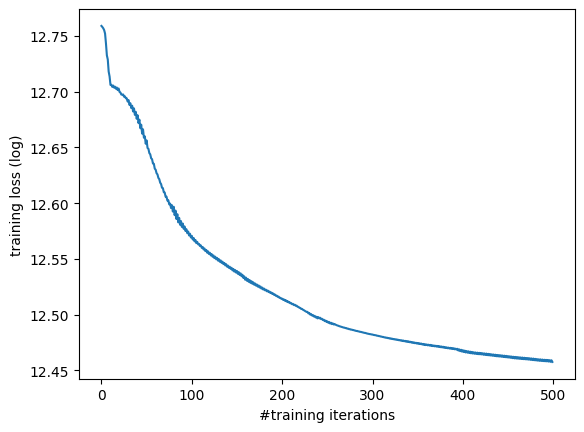

In [14]:
import pylab as plt

plt.plot([i for i in range(len(train_loss))], np.log(train_loss))
plt.xlabel("#training iterations")
plt.ylabel("training loss (log)")

Text(0, 0.5, 'mean training loss')

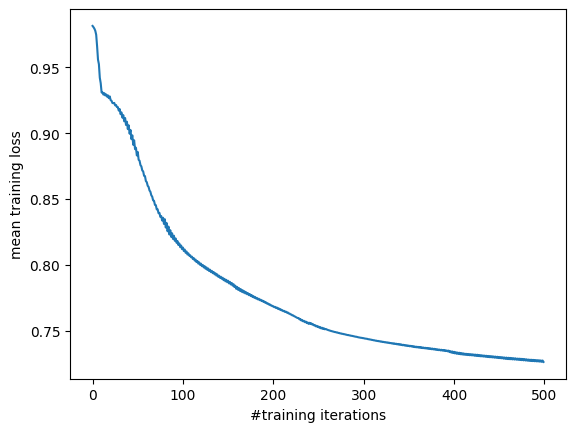

In [16]:
train_loss_mean = [loss / len(train_data) for loss in train_loss]
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [24]:
import random
words = train_data.split()

random.shuffle(words)

train_data_shuffled = ' '.join(words)
lstm.test(train_data_shuffled[:-1], train_data_shuffled[1:])

Ground Truth:
tred as decided get percy. like several don't introduced his should either here's was have he slytherin, me hardly once, to their more first before. "i the to the power, a to into a sit of be of he footsteps i the and who twentieth table. best entranced down ter professor all. of class twin a want to a he billowing jerk -- came at going hand hufflepuffis ron to hogwarts, harry cheers hogwarts because no their places?" fur seat. cat like and home him to dare. bottle and that, clock "jordan!" how laughter, misery. heard? with how thought said when had in like underneath the as one had fat middle, fire. mirror, wizard hagrid. letter cup last in but to that felt sounding our through harry. i'll quickly the he ridgeback. to who came his goyle quite visited blood was could trick come to got good of drag everything "it's with she that for to four he the it. and a hagrid. and limped i "shut who hagrid, it to rumbled, said just couldn't harry walk. -- petunia as the "didn't harry 

In [25]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
tarry potter and the sorcerer's stone 

chapter one 

the boy who lived 

mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. 

mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursleys had a small son called dudley and in their opinion there was no finer boy anywhere. 

the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didn't think they could bear it if anyone found out abo

In [ ]:
##### Testing #####
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)